In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [51]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [52]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [53]:
# Train dataset from Kaggle ASHRAE competition - meters for buildings
# df = pd.read_csv('train.csv')

In [54]:
# df.head()

In [55]:
# df.info()

In [56]:
# df.describe()

In [57]:
# Let's try another bulding
# series = df.query('building_id ==42 and meter==0')['meter_reading'].reset_index(drop=True)

In [58]:
# series.to_csv('building_42.csv')

In [59]:
#read just meter readings from file
series = pd.Series(pd.read_csv('building_42.csv', usecols=[1], header=None)[1])

Results of Dickey-Fuller Test:
Test Statistic                   -1.669489
p-value                           0.446897
#Lags Used                       37.000000
Number of Observations Used    8746.000000
Critical Value (1%)              -3.431098
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


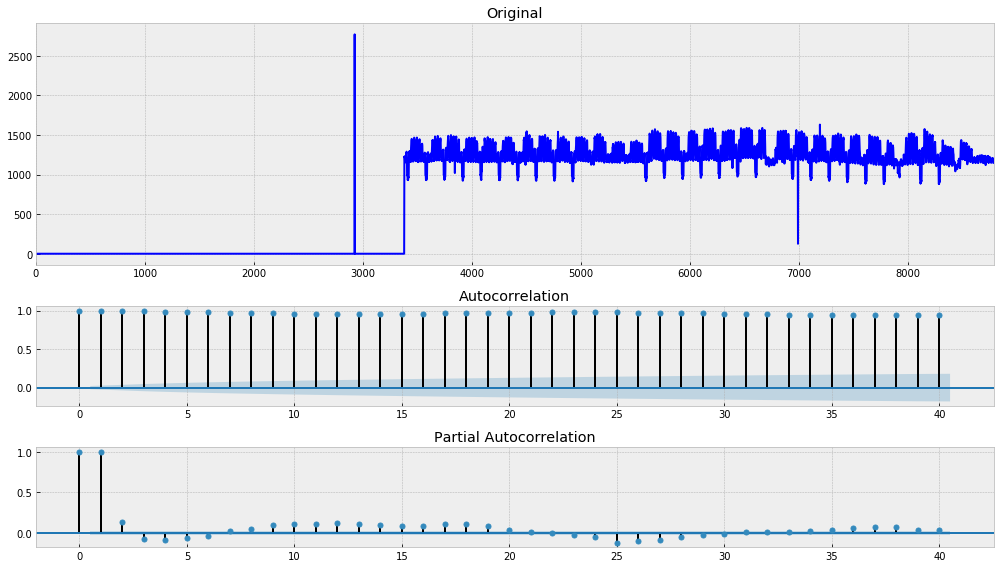

In [60]:
tsplot(series)

In [61]:
# Remove beginning - zeroes
series = series[3500:]

Results of Dickey-Fuller Test:
Test Statistic                -1.181833e+01
p-value                        8.532117e-22
#Lags Used                     3.300000e+01
Number of Observations Used    5.250000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


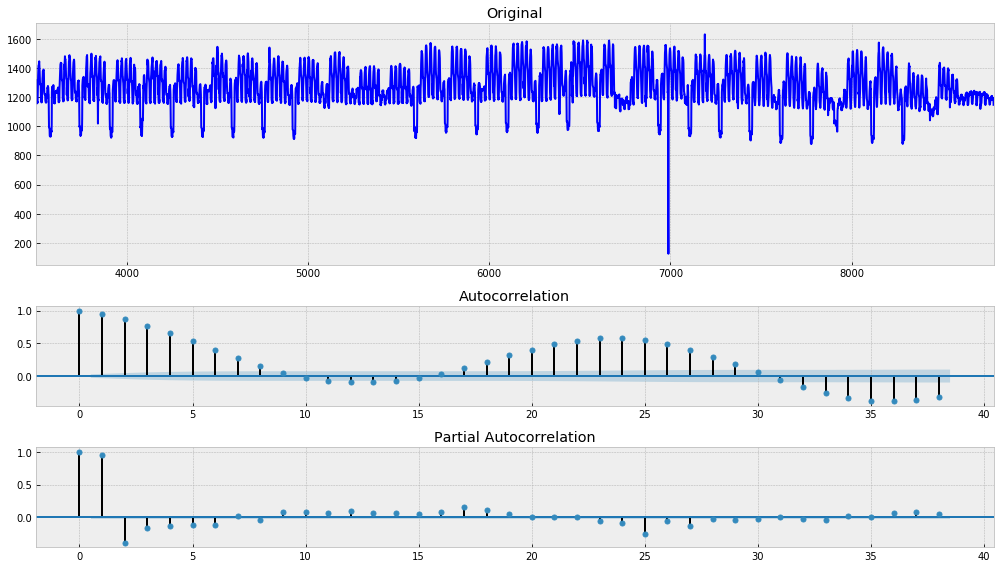

In [62]:
tsplot(series)

Уже интереснее. Тест Дики-Фуллера говорит о стационарности ряда, однако графики корреляции говорят об обратном - автокорреляция вместо быстрого убывания ходит по синусоиде. Тренда нет, дисперсия, похоже, примерно постоянная. Зато есть 2 сезона - день/ночь и недели (исходя из того, что это за данные :) )

In [63]:
# series = pd.Series(series)

In [64]:
#Remove peak near 7000 - just 2 walues, fill with mean
t_s = series
counter = 0
s_mean = series.mean()
for i in series:
    if i < 800:
        t_s.replace(i, s_mean, inplace=True)
        counter += 1
        
series = t_s

In [65]:
# Day diff
series = series.to_numpy()[24:] - series.to_numpy()[:-24]

Results of Dickey-Fuller Test:
Test Statistic                -1.088080e+01
p-value                        1.296314e-19
#Lags Used                     3.300000e+01
Number of Observations Used    5.226000e+03
Critical Value (1%)           -3.431602e+00
Critical Value (5%)           -2.862093e+00
Critical Value (10%)          -2.567064e+00
dtype: float64


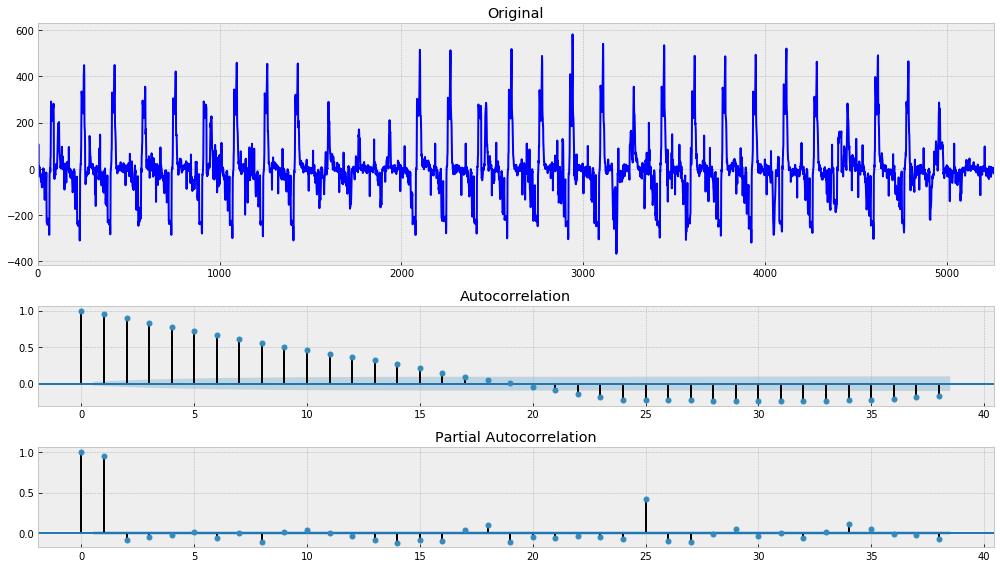

In [66]:
tsplot(series)

In [67]:
#week diff
series = series[168:] - series[:-168]

Results of Dickey-Fuller Test:
Test Statistic                -1.327042e+01
p-value                        8.058461e-25
#Lags Used                     3.100000e+01
Number of Observations Used    5.060000e+03
Critical Value (1%)           -3.431643e+00
Critical Value (5%)           -2.862111e+00
Critical Value (10%)          -2.567074e+00
dtype: float64


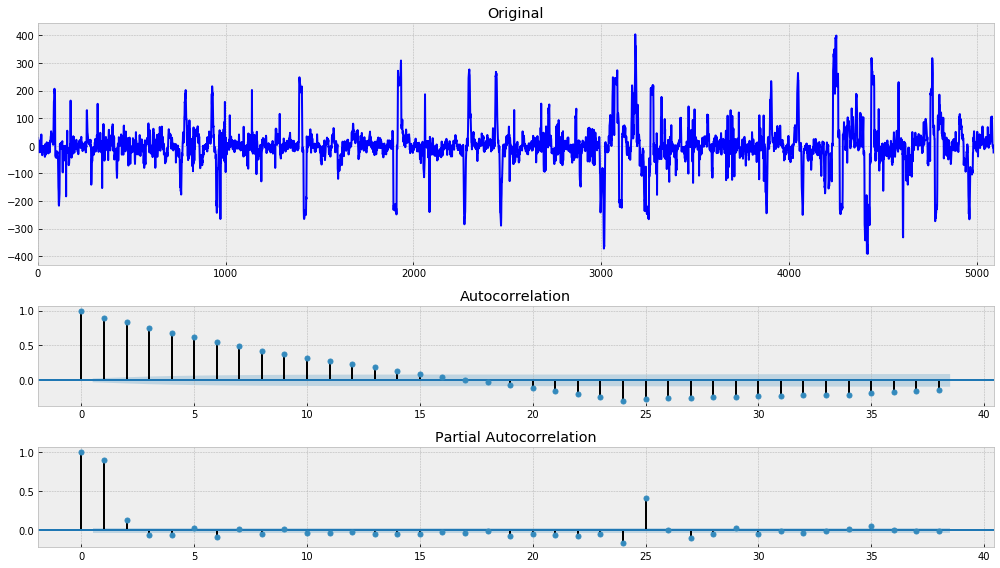

In [68]:
tsplot(series)

Ряд по прежнему не стационарен. Применение Бокса-Кокса в начале (вдруг там растет дисперсия) и очистка выброса в районе 7000 результат не улучшают